In [1]:
from dolfin import *
from mshr import *

In [2]:
# Generate mesh: a box minus one circular inclusion

r = .1   # inner radius of inclusion
L = 1.0  # dimension of outer box

Nc = 32 # number of segments in circular inclusion
Nb = 16 # number of cells per dimension in box

c = Point(0.3, 0.3) # center of inclusion

inclusion = Circle(c, r, segments=Nc)
box = Rectangle(Point(0, 0), Point(L, L))
outer_domain = box - inclusion
domain = outer_domain + inclusion

domain.set_subdomain(1, outer_domain)
domain.set_subdomain(2, inclusion)
mesh = generate_mesh(domain, Nb)
subdomains = MeshFunction("size_t", mesh, 2, mesh.domains())

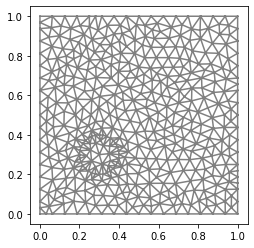

In [3]:
plot(mesh)

In [4]:
# Generate a submesh on the interface
marker = MeshFunction("size_t", mesh, 1 ,0)
for f in facets ( mesh ) :
    domains = []
    for c in cells(f):
       domains.append(subdomains[c])
    domains = list(set(domains)) # remove duplicates
    if len(domains) > 1: # it is on the interface
       marker[f] = 1
    
submesh = MeshView.create(marker,1)
n = CellNormal(submesh)

In [5]:
# Initialize function spaces and basis functions
V = FunctionSpace(mesh, "CG", 1)
LM = FunctionSpace(submesh, "CG", 1)

W = MixedFunctionSpace(V, LM)

(u, lam) = TrialFunctions(W)
(v, q) = TestFunctions(W)

In [6]:
# Dirichlet boundary condition everywhere
def boundary ( x, on_boundary ) :
    return on_boundary

bc = DirichletBC(V, Constant(0.0), boundary)

In [7]:
# Boundary data
g = Constant(1.0)

In [8]:
# Variational formulation
dV = Measure ( "dx" , domain = W.sub_space(0).mesh())
dL = Measure ( "dx" , domain = W.sub_space(1).mesh())

a1 = 1.0
a2 = 0.0

a = (inner(grad(u), grad(v))*dV + 
    a1*v*lam*dL + a1*u*q*dL 
    +a2*dot(grad(v),n)*lam*dL + a2*dot(grad(u),n)*q*dL)
L = g*q*dL

In [9]:
# Set linear solver parameters
prm = LinearVariationalSolver.default_parameters()
prm['linear_solver'] = 'gmres'
prm['krylov_solver']['maximum_iterations'] = 1000000

In [10]:
# Solve the problem
sol = Function(W)
solve (a == L, sol, bc, solver_parameters=prm)

In [11]:
# Save solution in VTK format
u = sol.sub(0)
lam = sol.sub(1)

u.rename("u", "bulk solution")
lam.rename("lam", "Lagrange multiplier")

bulk = File("bulk.pvd")
bulk << u

trace = File("trace.pvd")
trace << lam

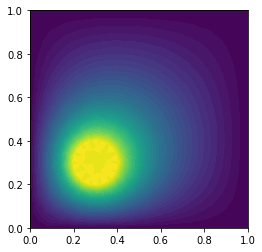

In [12]:
plot(u)